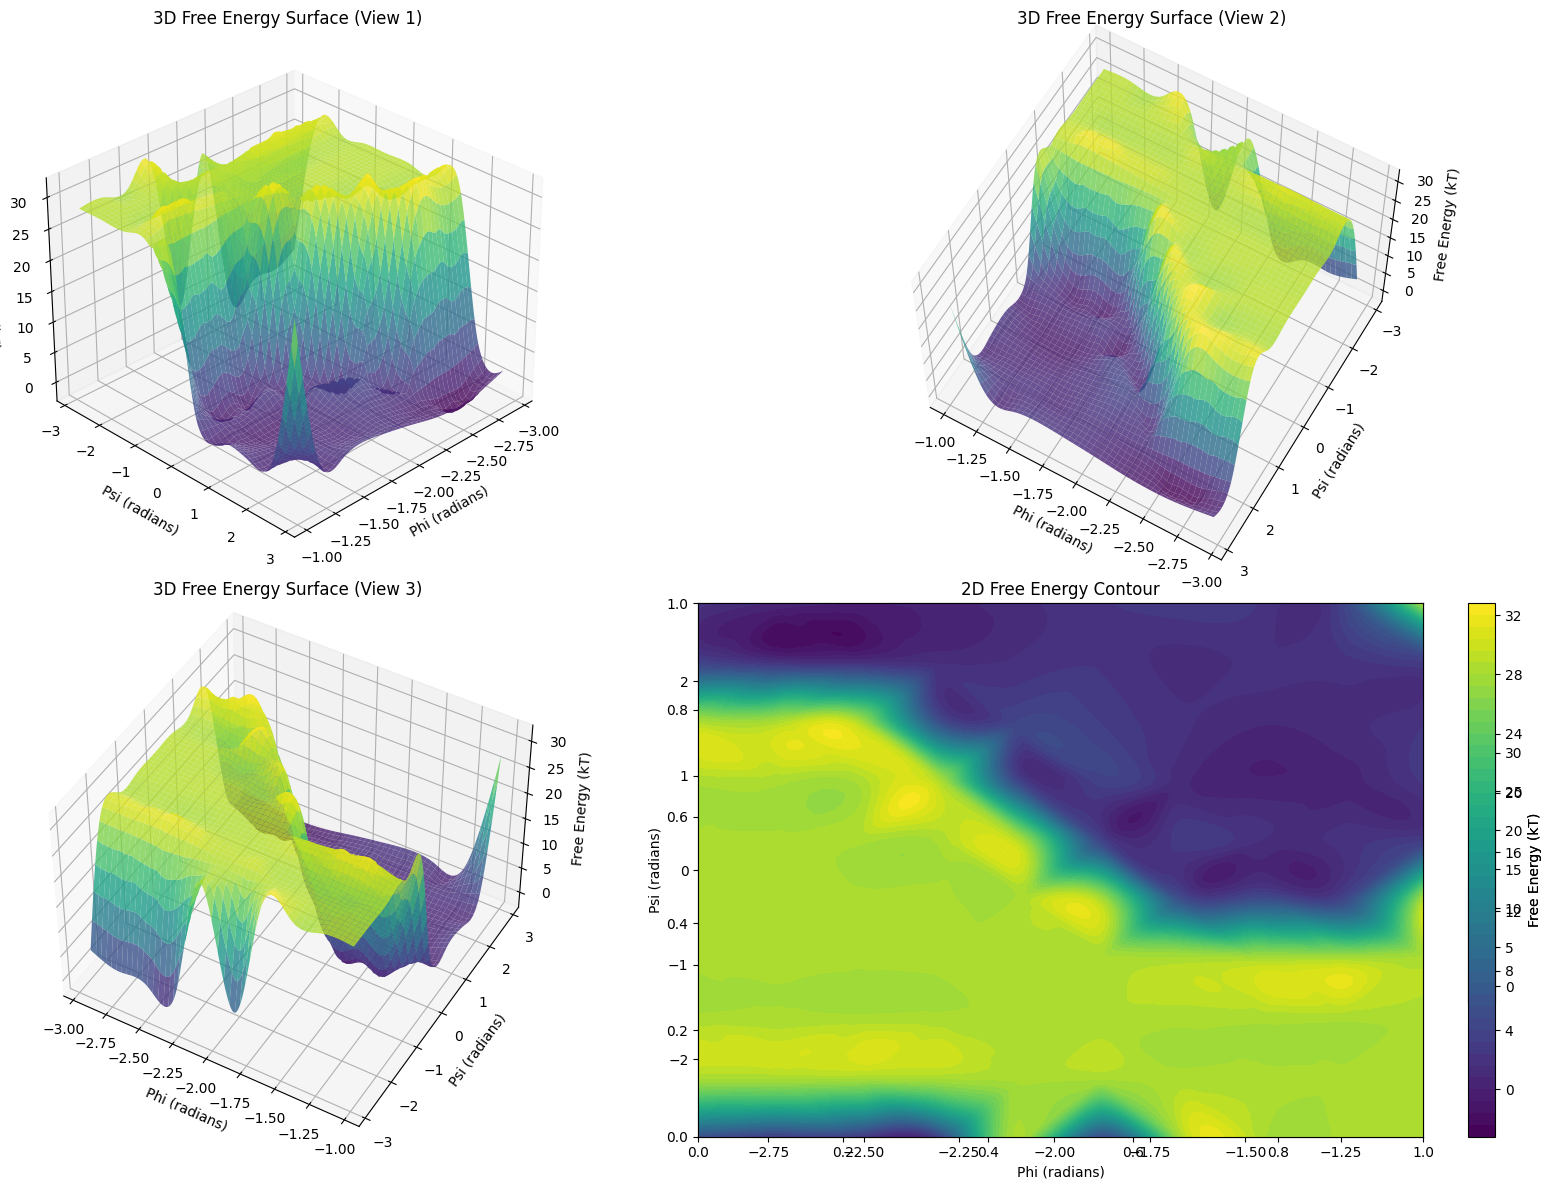

In [16]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# 加载轨迹
traj = md.load('adp.xtc', top='adp.gro')

# 计算 phi 和 psi 二面角
phi_indices = md.compute_phi(traj)[0]
psi_indices = md.compute_psi(traj)[0]
phi_angles = md.compute_dihedrals(traj, phi_indices)
psi_angles = md.compute_dihedrals(traj, psi_indices)

# 计算二维直方图，增加分辨率
bins = 10  # 增加bins数量，使表面更平滑
hist, x_edges, y_edges = np.histogram2d(phi_angles.flatten(), psi_angles.flatten(), bins=bins)

# 计算自由能面
fes = -np.log(hist + 1e-10)  # 避免log(0)的问题
fes -= np.min(fes)  # 使最小值为零

# 限制自由能最大值
fes_max = 60  # 设置自由能的最大值（可以根据需要调整）
fes = np.clip(fes, None, fes_max)

# 创建更高分辨率的网格
phi = (x_edges[:-1] + x_edges[1:]) / 2
psi = (y_edges[:-1] + y_edges[1:]) / 2
phi_grid, psi_grid = np.meshgrid(phi, psi)

# 将二维数据插值到更高分辨率的网格上
points = np.array([phi_grid.flatten(), psi_grid.flatten()]).T
values = fes.T.flatten()
phi_fine = np.linspace(phi.min(), phi.max(), 200)
psi_fine = np.linspace(psi.min(), psi.max(), 200)
phi_fine_grid, psi_fine_grid = np.meshgrid(phi_fine, psi_fine)
fes_fine = griddata(points, values, (phi_fine_grid, psi_fine_grid), method='cubic')

# 设置图像大小
fig = plt.figure(figsize=(18, 12))

# 绘制三个不同角度的三维自由能面图
angles = [(30, 45), (60, 120), (45, -60)]  # 不同视角 (elev, azim)

for i, angle in enumerate(angles, 1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    surf = ax.plot_surface(phi_fine_grid, psi_fine_grid, fes_fine, cmap='viridis', edgecolor='none', alpha=0.8)
    ax.view_init(elev=angle[0], azim=angle[1])
    ax.set_xlabel('Phi (radians)')
    ax.set_ylabel('Psi (radians)')
    ax.set_zlabel('Free Energy (kT)')
    ax.set_title(f'3D Free Energy Surface (View {i})')

# 添加颜色条
fig.colorbar(surf, ax=fig.add_subplot(2, 2, 4), orientation='vertical', shrink=0.5, aspect=10, label='Free Energy (kT)')

# 绘制二维色深图
ax2 = fig.add_subplot(2, 2, 4)
contour = ax2.contourf(phi_fine_grid, psi_fine_grid, fes_fine, levels=50, cmap='viridis')
fig.colorbar(contour, ax=ax2, orientation='vertical', label='Free Energy (kT)')
ax2.set_xlabel('Phi (radians)')
ax2.set_ylabel('Psi (radians)')
ax2.set_title('2D Free Energy Contour')

plt.tight_layout()
plt.show()
